### This is a simple language detection model with sklearn

First we import all the neccessary libraries, import the csv file and take a look at the data

In [240]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV

In [2]:
data = pd.read_csv("languages.csv")
data.head()

,text,language
0,ich denke es handelt sich hier um ein missvers...,german
1,ich habe tom gerade erst verlassen,german
2,tom versuchte mary nur zu ärgern,german
3,tom hat mir die hand geküsst,german
4,ich wusste dass dir das gefiele,german


In [157]:
data.language.value_counts()

english    275687
german     199618
french     169693
spanish    118686
Name: language, dtype: int64

In [158]:
data.isna().sum()

text        0
language    0
dtype: int64

In [159]:
plt_y = list(data.language.value_counts())
plt_x = list(set(data.language.values))

<BarContainer object of 4 artists>

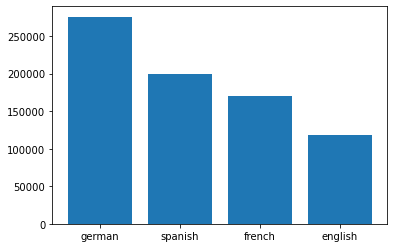

In [160]:
plt.bar(plt_x, plt_y)

In [3]:
## Shuffle the rows since a quick look at the table head lets us see that languages are strictly separated, 
## which is no good for the model

shuffled_data = data.sample(frac=1).reset_index(drop = True)
X_raw = shuffled_data["text"]
y_raw = shuffled_data["language"]

In [162]:
print(X_raw.shape)
print(y_raw.shape)

(763684,)
(763684,)


There are 4 different languages present in the table - english, german, spanish adn french. The data is not uniformaly distributed with french texts being 2.5 times less than for english. For now I do not see it as a problem, so I will leave it as is and separate the data to X (features) and y(target).

As the data comes in textual format, I will need to use a CountVectorizer to transform the text to bag-of-words dictionary. For target 4 language I will use LabelEncoder to transform. 

In [4]:
le = LabelEncoder()
y = le.fit_transform(y_raw)

In [5]:
cv = CountVectorizer()
X = cv.fit_transform(X_raw)

In [246]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

Now I initiate a Multinomial Bayes for classification, no hyperparameters are set at this point

In [247]:
# clf = MultinomialNB()
clf = CalibratedClassifierCV(MultinomialNB(), cv=3)

In [248]:
clf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=MultinomialNB(), cv=3)

In [249]:
clf.score(X_test, y_test)

0.9990113724899664

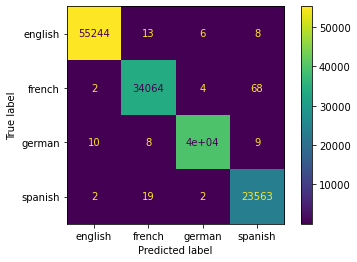

In [269]:
ConfusionMatrixDisplay((confusion_matrix(clf.predict(X_test), y_test)), display_labels=le.inverse_transform(clf.classes_)).plot()

The accuracy of the model is quite good and most of the predictions lie in the diagonal of the confusion matrix. Let us try o predict a few sentences in 4 languages and check how the model predict sentences with foregn borrowed words.

In [59]:
phrases = ["I will have pasta and pizza for dinner", 
           "Te hago un forward con toda la info",
           "Puis-je accéder à Internet avec Skype Zones",
           "Ich muß nach England telefonieren",
           "Voy del aeropuerto al hospital",
           "He has already called the doctor", 
           "Juan no viene al restaurante hoy",
           "Ci vediamo nel weekend", 
           "Facciamo una call conference in remote meeting su skype",
           "Espresso or cappuccino? I can't choose"]

for phrase in phrases:
    pred_array = clf.predict(cv.transform([phrase]))
    pred = le.inverse_transform(pred_array)
    pred_proba = clf.predict_proba(cv.transform([phrase]))
    ix = pred_proba.argmax(1)[0]
    print("{:55} - {:>10} with confidence {:.2%}".format(phrase, pred[0].title(), pred_proba[0,ix]))

I will have pasta and pizza for dinner                  -    English with confidence 99.91%
Te hago un forward con toda la info                     -    Spanish with confidence 99.95%
Puis-je accéder à Internet avec Skype Zones             -     French with confidence 99.94%
Ich muß nach England telefonieren                       -     German with confidence 99.91%
Voy del aeropuerto al hospital                          -    Spanish with confidence 99.95%
He has already called the doctor                        -    English with confidence 99.91%
Juan no viene al restaurante hoy                        -    Spanish with confidence 99.95%
Ci vediamo nel weekend                                  -     French with confidence 83.17%
Facciamo una call conference in remote meeting su skype -    English with confidence 99.90%
Espresso or cappuccino? I can't choose                  -    English with confidence 99.91%


The model is doing good on sentences with foreign borrowed words.

Now I will use a char bigram CountVectorized to preprocess the text, i.e. a word like "apple" will be transformed into following char bigrams "ap", "pp", "pl" and "le". My guess is that this method will be more accurate as the model learns to spot two-char clusters, instead of the whole word. In other words, the model is taught by internal structure (phonotactics) of the language rather than by the words present in the training set, which implies that it will have higher accuracy even with small training sets

In [251]:
cv_char = CountVectorizer(analyzer = 'char_wb', ngram_range=(2,4))
X_char = cv_char.fit_transform(X_raw)

In [252]:
X_train_char, X_test_char, y_train_char, y_test_char = train_test_split(X_char, y, test_size = 0.2, random_state = 1)

In [253]:
# another_clf = MultinomialNB()
another_clf = SGDClassifier(loss = "log", alpha = 1e-05, random_state=1)

In [254]:
another_clf.fit(X_train_char, y_train_char)

SGDClassifier(alpha=1e-05, loss='log', random_state=1)

In [255]:
y_pred_char = another_clf.predict(X_test_char)

In [256]:
accuracy_score(y_test_char, y_pred_char)

0.9994565822295842

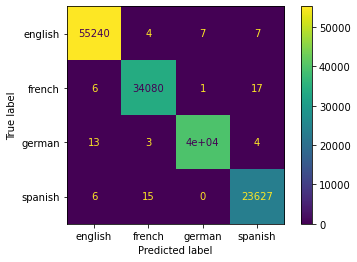

In [268]:
ConfusionMatrixDisplay((confusion_matrix(y_test, y_pred_char)), display_labels=le.inverse_transform(another_clf.classes_)).plot()

In [258]:
print(classification_report(y_test_char, y_pred_char))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55258
           1       1.00      1.00      1.00     34104
           2       1.00      1.00      1.00     39727
           3       1.00      1.00      1.00     23648

    accuracy                           1.00    152737
   macro avg       1.00      1.00      1.00    152737
weighted avg       1.00      1.00      1.00    152737



Let us use again the sentences above to predict tha language

In [69]:
phrases = ["I will have pasta and pizza for dinner", 
           "Te hago un forward con toda la info",
           "Puis-je accéder à Internet avec Skype Zones",
           "Ich muß nach England telefonieren",
           "Voy del aeropuerto al hospital",
           "He has already called the doctor", 
           "Juan no viene al restaurante hoy",
           "Ci vediamo nel weekend",
           "Facciamo una call conference in remote meeting su skype",
           "Espresso or cappuccino? I can't choose"]

for phrase in phrases:
    pred_array = another_clf.predict(cv_char.transform([phrase]))
    pred = le.inverse_transform(pred_array)
    pred_proba = another_clf.predict_proba(cv_char.transform([phrase]))
    ix = pred_proba.argmax(1)[0]
    print("{:55} - {:>10} with confidence {:.2%}".format(phrase, pred[0].title(), pred_proba[0,ix]))

I will have pasta and pizza for dinner                  -    English with confidence 100.00%
Te hago un forward con toda la info                     -    Spanish with confidence 99.99%
Puis-je accéder à Internet avec Skype Zones             -     French with confidence 99.97%
Ich muß nach England telefonieren                       -     German with confidence 99.99%
Voy del aeropuerto al hospital                          -    Spanish with confidence 99.96%
He has already called the doctor                        -    English with confidence 100.00%
Juan no viene al restaurante hoy                        -    Spanish with confidence 99.99%
Ci vediamo nel weekend                                  -    English with confidence 74.09%
Facciamo una call conference in remote meeting su skype -    English with confidence 71.14%
Espresso or cappuccino? I can't choose                  -    English with confidence 99.23%


This model seems to be more prone to errors when a sentence has forign words present. 